In [2]:
import numpy as np
import pandas as pd

import emcee
import corner

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import matplotlib.pyplot as plt
%matplotlib inline

from funcs.model import full_model_2flares, aflare, calculate_angular_radius

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

from matplotlib.lines import Line2D

In [3]:
ID = 44984200#237880881#212035340 #100004076#
tstamp = "04_08_2020_13_40"#'11_02_2020_10_07'

In [4]:
props = pd.read_csv(f"{CWD}/data/summary/everything.csv")
target = props[props.ID == ID].iloc[0]


In [5]:
inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
inits = inits[(inits.ID == str(ID)+"a")&(inits.tstamp==tstamp)].iloc[0]
qlum = inits.qlum_erg_s *u.erg/u.s
Fth = inits.Fth * u.erg/u.cm**2/u.s
median = inits.median
R = inits.R_Rsun *R_sun

In [6]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

In [7]:
target

ID                     44984200
QCS                          10
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                   custom
h_mission                  TESS
SpT                          M6
view_start              1587.25
view_stop               1589.75
view_min                   1620
view_max                   2200
BJDoff                  2457000
tstart                  1588.03
ampl_min                    0.5
ampl_max                    0.8
RA                      129.508
Dec                    -58.9331
J                        10.309
R                         15.08
Gaia_G                  14.4115
vsini_kms                   NaN
e_vsini_kms                 NaN
Prot_d                    0.113
sini                        NaN
Ref                   this work
identifier       SCR J0838-5855
Rstar                       NaN
idtyp                      tess
id                     44984200
st      

In [8]:
# see here https://emcee.readthedocs.io/en/stable/tutorials/monitor/
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}b_MCMC.h5"
reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
# burnin=70000
# thin=170
ndim=9
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))


burn-in: 2229
thin: 118
flat chain shape: (270560, 9)
flat log prob shape: (270560,)


In [ ]:


columns = ["phase_peak_a", "phase_peak_b", "latitude_rad",
           "a_a", "a_b", "fwhm_periods_a", "fwhm_periods_b",
           "i_rad","phase_0"]

rawsamples = pd.DataFrame(data=samples, columns=columns)

for suffix in ["a","b"]:
    rawsamples1 = rawsamples[[f"phase_peak_{suffix}",
                               "latitude_rad",
                               f"a_{suffix}",
                               f"fwhm_periods_{suffix}",
                               "i_rad",
                               "phase_0"]]
    rawsamples2 = rawsamples1.rename(index=str, 
                                    columns=dict(zip([f"phase_peak_{suffix}",
                                                      f"a_{suffix}",
                                                      f"fwhm_periods_{suffix}"],
                                                     ["phase_peak",
                                                      "a",
                                                      "fwhm_periods"])))
    rawsamples2.to_csv(f"{CWD}/analysis/results/mcmc/"
                       f"{tstamp}_{target.ID}{suffix}"
                       f"_raw_mcmc_sample.csv",
                       index=False)



In [ ]:
from get_mcmc_outputs import write_meta_mcmc
write_meta_mcmc(CWD, tstamp, target.ID, burnin, samples.shape[0], samples.shape[1], ndim)

# Plots
### Plot the full chain

In [ ]:
fig, axes = plt.subplots(9, figsize=(10, 15), sharex=True)

multi_samples = reader.get_chain()
walkers = multi_samples.shape[1]
steps = multi_samples.shape[0]
nparam = multi_samples.shape[2]
# -----------------------------------------------------------------------
#map phi_a_distr to t0_distr:
for i in [0,1]:
    multi_samples[:, :,i] = np.interp(multi_samples[:,:,i],lc.phi,lc.t)

# convert theta_f to degrees
multi_samples[:, :,2] = multi_samples[:,:, 2] / np.pi * 180.

# convert FWHM to days
for i in [5,6]:
    multi_samples[:,:, i] = multi_samples[:,:, i]/2/np.pi*target.Prot_d 

# convert i to degrees
multi_samples[:,:, -2] = multi_samples[:,:, -2] / np.pi * 180.

# map phi0 to phi_peak longitude, still call it phi0
multi_samples[:,:, -1] = (multi_samples[:, :,0]%(2.*np.pi) - multi_samples[:,:, -1]) / np.pi * 180. # 0 would be facing the observer
# -----------------------------------------------------------------------
labels = [r'$t_\mathrm{f,1} [d]$', r'$t_\mathrm{f,2} [d]$',
          r'$\theta_\mathrm{f}$ [deg]', 
          r'$a_1$', r'$a_2$',
          r'FWHM$_1$ [d]', r'FWHM$_2$ [d]', 
          r'$i$ [deg]',
          r"$\phi_\mathrm{f}$ [deg]"]
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
for j in range(ndim):
    ax = axes[j]
    ax.plot(multi_samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(multi_samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_chain.png",dpi=300)

In [ ]:
# with open(f"{CWD}/analysis/results/mcmc/mcmc_meta.csv","a") as f:
#     #Add more lines here
    
#     out = f"{tstamp},{target.ID},{burnin},{steps},{walkers},{nparam},{ndim},{thin}"
#     firstout = f"date,ID,burnin,steps,walkers,nparam,ndim, thin"
#     out += "\n"
#     firstout += "\n"
#     f.write(firstout)
#     f.write(out)

In [ ]:

#map phi_a_distr to t0_distr:
for i in [0,1]:
    samples[:, i] = np.interp(samples[:,i],lc.phi,lc.t)

# convert theta_f to degrees
samples[:, 2] = samples[:, 2] / np.pi * 180.

# convert FWHM to days
for i in [5,6]:
    samples[:, i] = samples[:, i]/2/np.pi*target.Prot_d 

# convert i to degrees
samples[:, -2] = samples[:, -2] / np.pi * 180.

# map phi0 to phi_peak longitude, still call it phi0
samples[:, -1] = (samples[:, 0]%(2.*np.pi) - samples[:, -1]) / np.pi * 180. # 0 would be facing the observer





### Corner plot

In [ ]:
fig = corner.corner(samples, labels=labels)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_corner_disc{burnin}.png",dpi=300)

In [ ]:
0.37 / np.pi *180
median

### Retrieve and plot some example fits to the data from the chain

findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.


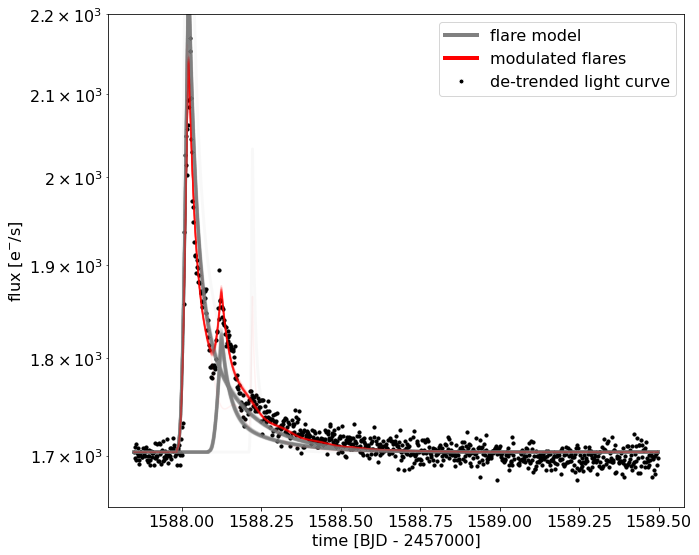

In [9]:
flat_samples = reader.get_chain(discard=burnin+500000, flat=True, thin=thin)
N = 50
phi = lc.phi.values
time = lc.t
flux = lc.flux.values
median = lc.median_[0]
inds = np.random.randint(len(flat_samples), size=N)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(time, flux, s=10, c="k", label=r"de-trended light curve")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    phi_a1, phi_a2, theta_a, a1, a2, fwhm1, fwhm2, i, phi0 = sample
    plt.plot(time, aflare(phi, phi_a1, fwhm1, a1*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(time, aflare(phi, phi_a2, fwhm2, a2*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(time, full_model_2flares((phi_a1,phi_a2), theta_a, (a1,a2), (fwhm1,fwhm2), i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=0.05,)
    

legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                   Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                   Line2D([0], [0], marker='o', color='w', label="de-trended light curve",
                          markerfacecolor='k', markersize=5),
                  ]
plt.legend(handles=legend_elements, fontsize=16)
plt.xlabel(f"time [BJD - {target.BJDoff}]",fontsize=16)
plt.ylabel(r"flux [e$^{-}$/s]",fontsize=16);
plt.yscale("log")
#plt.ylim(590,2070)
#plt.xlim(1331.5,1332.75)
plt.ylim(1650,2200)
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flarefit_{N}retrievals.png",dpi=300)

In [ ]:
columns = ["t0_d_a","t0_d_b","latitude_deg",
           "a_a","a_b","fwhm_d_a", 
           "fwhm_d_b","i_deg","phase_deg"]

rawsamples = pd.DataFrame(data=samples, columns=columns)

for suffix in ["a","b"]:
    rawsamples1 = rawsamples[[f"t0_d_{suffix}",
                               "latitude_deg",
                               f"a_{suffix}",
                               f"fwhm_d_{suffix}",
                               "i_deg",
                               "phase_deg"]]
    rawsamples2 = rawsamples1.rename(index=str, 
                                    columns=dict(zip([f"t0_d_{suffix}",
                                                      f"a_{suffix}",
                                                      f"fwhm_d_{suffix}"],
                                                     ["t0_d",
                                                      "a",
                                                      "fwhm_d"])))
    rawsamples2.to_csv(f"{CWD}/analysis/results/mcmc/"
                       f"{tstamp}_{target.ID}{suffix}"
                       f"_converted_mcmc_sample.csv",
                       index=False)